# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

**핵심적인 기법들을 하나씩 제거했을 때의 효과를 각각 정량적으로 측정하는 ablation study 기법을 배운다. ResNet을 대상으로 실습해 보면서 이론적으로 익힌 기법의 효과를 체감하고 백본을 직접 다뤄보는 실전적 감각을 익힌다.**

## 2-7. 프로젝트: ResNet Ablation Study

---

## 목차
- 0) 라이브러리 버전 확인하기
- 1) ResNet 기본 블록 구성하기
- 2) ResNet-34, ResNet-50 Complete Model
- 3) 일반 네트워크(plain network) 만들기
- 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

---

### 라이브러리 임포트 및 확인

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [69]:
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.3.5
1.21.5


### GPU 확인

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 상수 설정
- BATCH_SIZE 가 클수록 훈련 시간 단축, 1 EPOCH 당 1분 이상 소요됨
- 데이터셋 CIFAR-10 의 경우 40 EPOCHS 정도 수행하는 것을 권장, 15 EPOCHS 정도로도 근접한 성능 얻을 수 있음
- batch_size 와 learning_rate 최고의 조합 찾기 [[참고]](https://inhovation97.tistory.com/32)
    - Best
        - 작은 batch, 낮은 lr (e.g. 16, 0.0001)
        - 큰 batch, 높은 lr (e.g. 256, 0.001)
    - Worst
        - 작은 batch, 높은 lr (e.g. 16, 0.001)
        - 큰 batch, 낮은 lr (e.g. 256, 0.0001)

In [4]:
BATCH_SIZE = 32  # 256
EPOCHS = 10  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

### 데이터 가져와서 확인
- ds_info = tfds.load(): 기본적으로 ~/tensorflow_datasets 경로에 데이터셋 다운로드
- Tensorflow의 데이터셋은 Numpy가 아님 => 다른 방법으로 정보 확인해야 함!
    - ds_info.features  # feature 정보 확인
    - tf.data.experimental.cardinality(ds_train)  # 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 확인

- 데이터셋 다운로드
    - tfds.load()

In [5]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete9GO6O4/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


- 데이터셋 features 확인
    - ds_info: 데이터셋의 메타 정보

In [6]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


- 데이터셋 개수 확인
    - Tensorflow 데이터셋은 Numpy 가 아님 => ds_train.shape 사용 불가
    - tf.data.experimental.cardinality(ds_train) 로 확인

In [7]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


- 데이터셋 클래스 개수 및 구성 확인

In [8]:
ds_info.features["label"].num_classes  # 2

2

In [9]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

- 각 이미지 클래스와 인덱스 확인
    - 학습용 데이터셋 확인
    - 평가용 데이터셋 확인

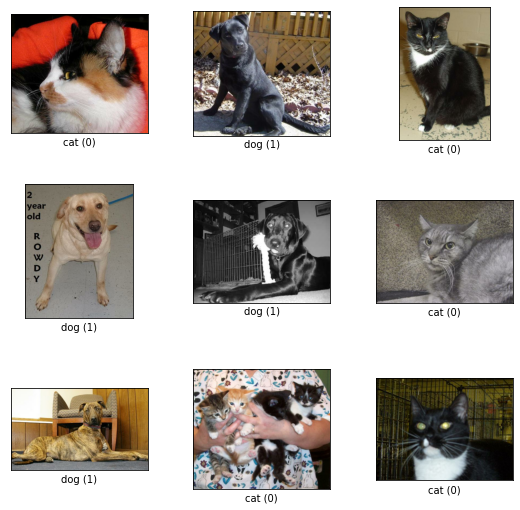

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

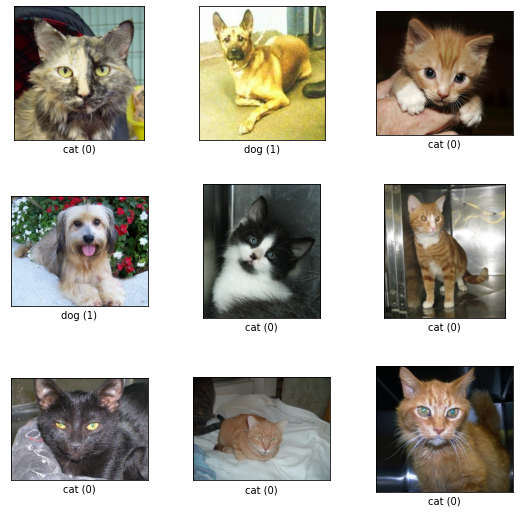

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

### Input Normalization
- Data Normalization: 데이터의 범위를 사용자가 원하는 범위로 제한하는 것
    - 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 [0, 1] 사이의 값을 가짐
    - f(x) = $\frac{x-x_{min}}{x_{max}-x_{min}}$
    - 사용 이유
        - 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지
        - 딥러닝에서 Local optimum에 빠질 위험을 줄임(학습 속도 향상)
    - scikit-learn에서 MinMaxScaler로 쉽게 사용
- 모델에 넣어주기 전에 각 채널별 최댓값인 255로 정규화(normalize)

- 데이터 전처리
    - 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용

In [12]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

- 전처리 포함한 배치 구성

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- 데이터셋에 전처리와 배치 처리 적용

In [14]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- 구성된 배치 모양 확인

In [15]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


### ResNet, Plain 구현

- 블록을 단위로 모델을 만들 수 있어야 함!
    - 블록(block): 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위
    - 레이어(layer): 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위
- ResNet
    - ResNet-18, 34, 50, 101, 152<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/resnet.max-800x600.png)
- Plain: ResNet 에서 Residual Block 이 없는 형태
    - ResNet-34, Plain-34<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/F-22-14.max-800x600.png)

#### 블록 생성 함수

In [16]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [17]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

#### 모델 생성 함수

In [18]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

#### 모델 생성 및 확인

- ResNet-34, ResNet-50 생성

In [19]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [20]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

- Plain-34, Plain-50 생성

In [21]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [22]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

### ResNet vs Plain 비교

#### 학습

- 모델 학습 함수
    - 데이터셋이 작을 경우, Adam 보다 SGD 가 더 학습에 유리하다.

In [23]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

- ResNet-34 학습

In [24]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 90s 119ms/step - loss: 2.3133 - accuracy: 0.5617 - val_loss: 2.0866 - val_accuracy: 0.5539
Epoch 2/10
581/581 [==============================] - 66s 114ms/step - loss: 1.9254 - accuracy: 0.6173 - val_loss: 2.0939 - val_accuracy: 0.5147
Epoch 3/10
581/581 [==============================] - 66s 114ms/step - loss: 1.6739 - accuracy: 0.6419 - val_loss: 1.7563 - val_accuracy: 0.5237
Epoch 4/10
581/581 [==============================] - 67s 115ms/step - loss: 1.4481 - accuracy: 0.6867 - val_loss: 1.4261 - val_accuracy: 0.6602
Epoch 5/10
581/581 [==============================] - 66s 114ms/step - loss: 1.2431 - accuracy: 0.7411 - val_loss: 1.2778 - val_accuracy: 0.6628
Epoch 6/10
581/581 [==============================] - 66s 114ms/step - loss: 1.0778 - accuracy: 0.7849 - val_loss: 1.2642 - val_accuracy: 0.6858
Epoch 7/10
581/581 [==============================] - 67s 115ms/step - loss: 0.9116 - accuracy: 0.8336 - val_loss: 1.2866 - val_ac

- Plain-34 학습

In [25]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 75s 110ms/step - loss: 2.1226 - accuracy: 0.5181 - val_loss: 1.9626 - val_accuracy: 0.4918
Epoch 2/10
581/581 [==============================] - 64s 109ms/step - loss: 1.8234 - accuracy: 0.5489 - val_loss: 1.7146 - val_accuracy: 0.5227
Epoch 3/10
581/581 [==============================] - 64s 110ms/step - loss: 1.6079 - accuracy: 0.5577 - val_loss: 1.5359 - val_accuracy: 0.5032
Epoch 4/10
581/581 [==============================] - 64s 110ms/step - loss: 1.4310 - accuracy: 0.5914 - val_loss: 1.3729 - val_accuracy: 0.6004
Epoch 5/10
581/581 [==============================] - 64s 110ms/step - loss: 1.2920 - accuracy: 0.6112 - val_loss: 1.2223 - val_accuracy: 0.6292
Epoch 6/10
581/581 [==============================] - 64s 110ms/step - loss: 1.1746 - accuracy: 0.6329 - val_loss: 1.1528 - val_accuracy: 0.5970
Epoch 7/10
581/581 [==============================] - 64s 110ms/step - loss: 1.0833 - accuracy: 0.6429 - val_loss: 1.0536 - val_ac

- ResNet-50 학습

In [26]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 70s 95ms/step - loss: 5.7664 - accuracy: 0.5400 - val_loss: 5.0718 - val_accuracy: 0.5668
Epoch 2/10
581/581 [==============================] - 54s 94ms/step - loss: 4.5947 - accuracy: 0.6164 - val_loss: 4.1892 - val_accuracy: 0.6058
Epoch 3/10
581/581 [==============================] - 55s 94ms/step - loss: 3.8095 - accuracy: 0.6678 - val_loss: 3.6707 - val_accuracy: 0.5675
Epoch 4/10
581/581 [==============================] - 55s 94ms/step - loss: 3.2072 - accuracy: 0.7037 - val_loss: 3.3687 - val_accuracy: 0.5561
Epoch 5/10
581/581 [==============================] - 55s 94ms/step - loss: 2.7237 - accuracy: 0.7389 - val_loss: 2.8358 - val_accuracy: 0.6321
Epoch 6/10
581/581 [==============================] - 55s 95ms/step - loss: 2.3414 - accuracy: 0.7644 - val_loss: 2.2293 - val_accuracy: 0.7385
Epoch 7/10
581/581 [==============================] - 55s 95ms/step - loss: 2.0263 - accuracy: 0.7884 - val_loss: 2.0336 - val_accuracy:

- Plain-50 학습

In [27]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 103s 154ms/step - loss: 4.8799 - accuracy: 0.5073 - val_loss: 4.3861 - val_accuracy: 0.5284
Epoch 2/10
581/581 [==============================] - 89s 153ms/step - loss: 4.0194 - accuracy: 0.5048 - val_loss: 3.6742 - val_accuracy: 0.5198
Epoch 3/10
581/581 [==============================] - 89s 153ms/step - loss: 3.3918 - accuracy: 0.4995 - val_loss: 3.1310 - val_accuracy: 0.4769
Epoch 4/10
581/581 [==============================] - 89s 153ms/step - loss: 2.9056 - accuracy: 0.5096 - val_loss: 2.6989 - val_accuracy: 0.5136
Epoch 5/10
581/581 [==============================] - 89s 153ms/step - loss: 2.5235 - accuracy: 0.5074 - val_loss: 2.3643 - val_accuracy: 0.5093
Epoch 6/10
581/581 [==============================] - 89s 154ms/step - loss: 2.2217 - accuracy: 0.5060 - val_loss: 2.0910 - val_accuracy: 0.5149
Epoch 7/10
581/581 [==============================] - 89s 154ms/step - loss: 1.9802 - accuracy: 0.5074 - val_loss: 1.8711 - val_a

#### 학습 결과 시각화 및 저장

- ResNet-34, Plain-34
    - Training Loss
    - Training Accuracy

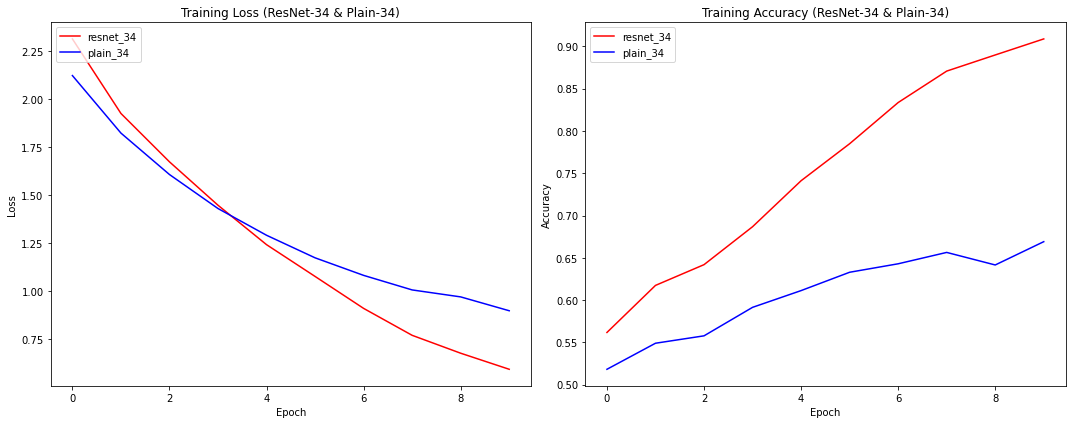

In [66]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_34.png')

plt.show()

- ResNet-50, Plain-50
    - Training Loss
    - Training Accuracy

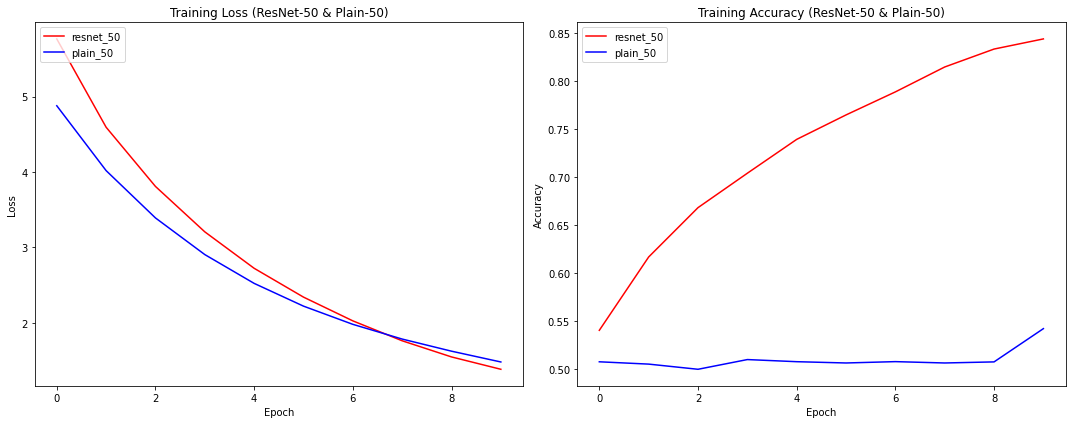

In [65]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
    - Training Loss
    - Training Accuracy

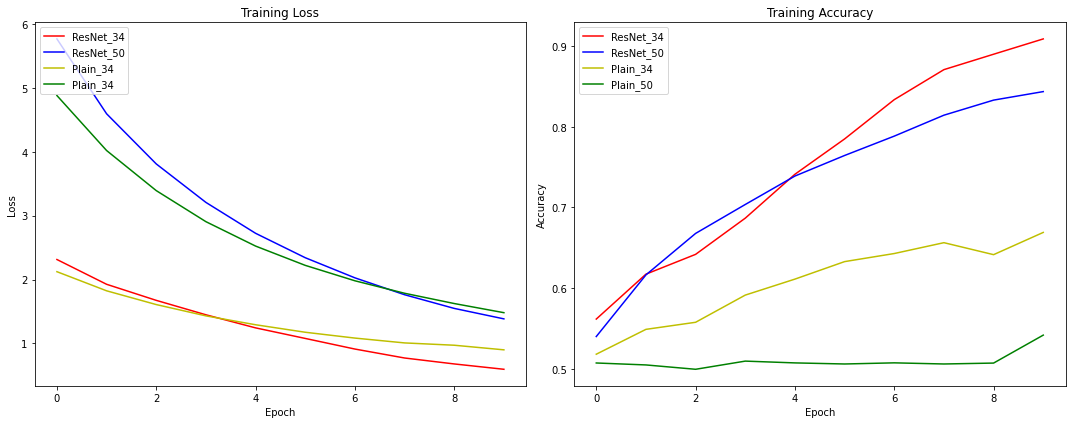

In [64]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_All.png')

plt.show()

- ResNet-34, Plain-34
    - Validation Loss
    - Validation Accuracy

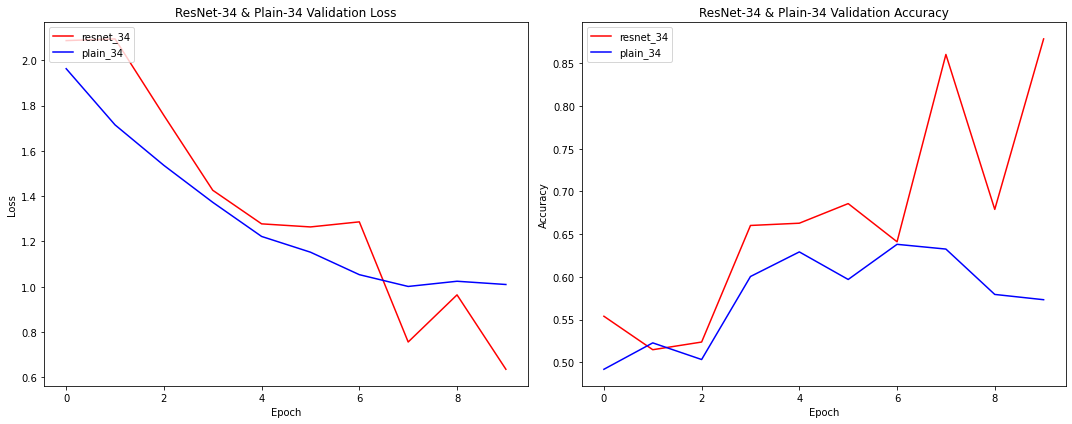

In [63]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_34.png')

plt.show()

- ResNet-50, Plain-50
    - Validation Loss
    - Validation Accuracy

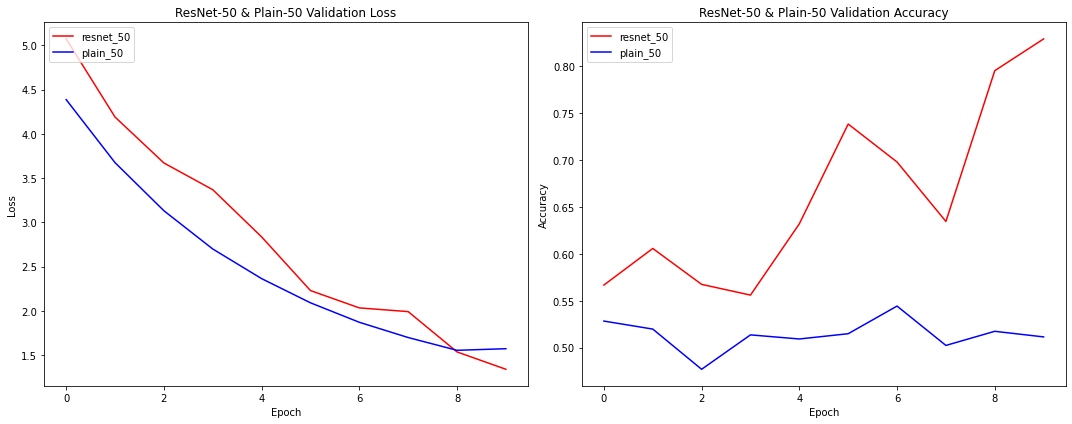

In [62]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
    - Validation Loss
    - Validation Accuracy

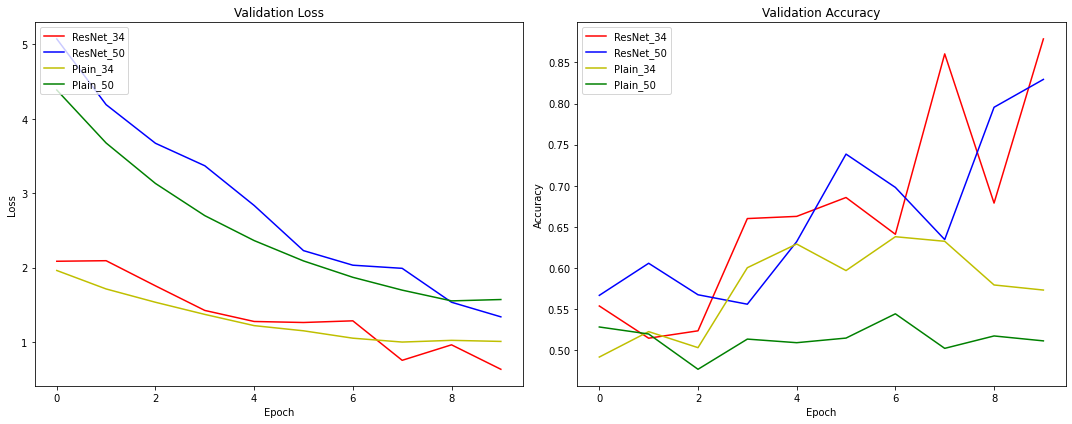

In [67]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_All.png')

plt.show()

### 학습 결과 데이터 프레임으로 확인

- ResNet, Plain 학습 결과 데이터 프레임으로 저장

In [86]:
# ResNet, Plain 학습 결과 평균값을 딕셔너리로 저장
model_result = {
    'ResNet-34': [
        round(np.array(history_resnet_34.history['loss']).mean(), 2),
        round(np.array(history_resnet_34.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_34.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_34.history['val_accuracy']).mean(), 2)
    ],
    'Plain-34': [
        round(np.array(history_plain_34.history['loss']).mean(), 2),
        round(np.array(history_plain_34.history['accuracy']).mean(), 2),
        round(np.array(history_plain_34.history['val_loss']).mean(), 2),
        round(np.array(history_plain_34.history['val_accuracy']).mean(), 2)
    ],
    'ResNet-50': [
        round(np.array(history_resnet_50.history['loss']).mean(), 2),
        round(np.array(history_resnet_50.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_50.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_50.history['val_accuracy']).mean(), 2)
    ],
    'Plain-50': [
        round(np.array(history_plain_50.history['loss']).mean(), 2),
        round(np.array(history_plain_50.history['accuracy']).mean(), 2),
        round(np.array(history_plain_50.history['val_loss']).mean(), 2),
        round(np.array(history_plain_50.history['val_accuracy']).mean(), 2)
    ],    
}

# 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

,ResNet-34,Plain-34,ResNet-50,Plain-50
Training Loss,1.26,1.34,2.92,2.68
Training Accuracy,0.75,0.61,0.73,0.51
Validation Loss,1.35,1.31,2.83,2.50
Validation Accuracy,0.67,0.58,0.66,0.51


- Validation Accuracy 기준으로 Ablation Study 결과표 작성

In [87]:
df_val_acc = pd.DataFrame(df_model_result.loc['Validation Accuracy'], columns=['Validation Accuracy'])
df_val_acc

,Validation Accuracy
ResNet-34,0.67
Plain-34,0.58
ResNet-50,0.66
Plain-50,0.51


---

### 결과 정리

- 시각화 비교

||Training<br>Loss and Accuracy|Validation<br>Loss and Accuracy|
|:---:|:---:|:---:|
|34|![](result/Training_Loss_and_Accuracy_of_34.png)|![](result/Validation_Loss_and_Accuracy_of_34.png)|
|50|![](result/Training_Loss_and_Accuracy_of_50.png)|![](result/Validation_Loss_and_Accuracy_of_50.png)|
|All|![](result/Training_Loss_and_Accuracy_of_All.png)|![](result/Validation_Loss_and_Accuracy_of_All.png)|

- 결과 비교

In [79]:
# ResNet-34, Plain-34, ResNet-50, Plain-50 학습 결과
df_model_result

,ResNet-34,Plain-34,ResNet-50,Plain-50
Training Loss,1.26,1.34,2.92,2.68
Training Accuracy,0.75,0.61,0.73,0.51
Validation Loss,1.35,1.31,2.83,2.50
Validation Accuracy,0.67,0.58,0.66,0.51


In [85]:
# Validation Accuracy 기준으로 결과 확인
df_val_acc

,Validation Accuracy
ResNet-34,0.67
Plain-34,0.58
ResNet-50,0.66
Plain-50,0.51


- 결론

epochs=10 으로 학습을 진행했다. Training Loss, Validation Loss 는 epoch 이 진행될수록 ResNet 이 PlainNet 보다 값이 작아졌고 Training Accuracy, Validation Accuracy 는 시작부터 압도적으로 ResNet 이 PlainNet 보다 값이 컸다. PlainNet 에 비해 ResNet 의 성능이 개선되었음을 알 수 있다. _좀 더 결과를 보고 싶다면 epochs=40 이상으로 진행해보면 좋을 것이다._

=> **성능: ResNet > PlainNet**

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
VGG 구현하는 방식을 알려줬으나 그걸 토대로 ResNet 논문을 코드로 구현하는 건 여전히 어렵다. 구글링과 펀더멘탈 22 코드를 참고할 수 밖에 없었다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- Ablation Study [[참고1]](https://cumulu-s.tistory.com/8) [[참고2]](https://fintecuriosity-11.tistory.com/73)
    - 의학/심리학 연구: 장기, 조직, 혹은 살아있는 유기체의 어떤 부분을 수술적인 제거 후에 이것이 없을때 해당 유기체의 행동을 관찰하는 것을 통해서 장기, 조직, 혹은 살아있는 유기체의 어떤 부분의 역할이나 기능을 실험해보는 방법
    - 머신러닝
        - machine learning system의 building blocks을 제거해서 전체 성능에 미치는 효과에 대한 insight를 얻기 위한 과학적 실험
        - "An ablation study typically refers to removing some "feature" of the model of algorithm, and seeing how that affects performance".
    - ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlWXxn%2FbtqGCect7wb%2FII68a8fSRJ6g1BNtqatxHk%2Fimg.png)
- ResNet & Plain 구조<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdek2kD%2FbtqTfCx4XTn%2FkMHkA7Fv8vbW5Hkmg1x3a0%2Fimg.png)
- ResNet
    - 잔차(Residual)<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbmdg7R%2FbtqYDjgD1TR%2Fp6qeoRgyJlJvBjKnTPNB9k%2Fimg.png)
        - 최적의 H(x)를 찾는 것이 아니라 H(x) - x를 찾는 것
        - 이전 layer의 결과를 다시 이용하는 것
        - 입력에서 출력으로 바로 연결되는 shortcut만 추가 => 파라미터 수에 영향이 없으며, 덧셈이 늘어나는 것을 제외하면 shortcut 연결을 통한 연산량 증가는 없다. => forward와 backward path가 단순해지는 효과가 있었으며, gradient의 소멸 문제를 해결할 수 있다.
        - 심층신경망의 degradation 문제 해결
    - 구조
        - VGG-19 구조를 뼈대로 함
        - 3x3 Convolution, Max pooling 한 번 사용, Hidden FC, Dropout을 사용하지 않음
        - 50/101/152 Layer는 Bottleneck이라는 구조로 변경
            - bottleneck design은 신경망의 복잡도를 감소하기 위해 사용<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FB5i5c%2FbtqYDjnmO9t%2F4mYzLdkp1eIeUUs68vkepK%2Fimg.png)
        - Plain 모델에 기반하여 Shortcut connection을 추가하여 구성
            - shortcut이 feature map을 2 size씩 건너뛰므로 stride를 2로 설정
        - input과 output의 차원
            - 같다면, identity shortcut을 바로 사용
            - dimension이 증가했을 경우
                - zero padding을 적용하여 차원을 키움
                - projection shortcut을 사용 (1x1 conv)
    - 참고
        - 코드 구현 참고: [[1]](https://git.dst.etit.tu-chemnitz.de/external/tf-models/-/blob/1d057dfc32f515a63ab1e23fd72052ab2a954952/official/vision/image_classification/resnet_model.py) [[2]](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py#L20) [[3]](https://github.com/calmisential/TensorFlow2.0_ResNet/blob/master/models/resnet.py)
        - ResNet 구조 참고: [[1]](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) [[2]](https://oi.readthedocs.io/en/latest/computer_vision/cnn/resnet.html)
        - 논문 리뷰 참고: [[1]](https://phil-baek.tistory.com/entry/ResNet-Deep-Residual-Learning-for-Image-Recognition-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0) [[3]](https://deep-learning-study.tistory.com/473) [[2]](https://youtu.be/671BsKl8d0E)
- Plain
    - skip/shortcut connection을 사용하지 않은 일반적인 CNN(AlexNet, VGGNet) 신경망
    - plaing network가 점점 깊어질 수록 기울기(gradient) 소실(vanishing)과 폭발(exploding) 문제가 발생
    - 구조
        - conv filter의 사이즈 3 x 3
        - stride가 2인 conv filter를 사용
        - GAP를 사용
        - 사이즈가 1,000인 FC layer와 Softmax를 사용


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
>|2|구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
>|3|Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

블록 함수를 만든 다음 모델(ResNet-34, ResNet-50, Plain-34, Plain-50)을 구현하고 summary 를 출력했다. 구글링과 펀더멘탈 22 를 참고했다.

모든 모델의 학습은 epochs=10 으로 진행한 후 ResNet 과 PlainNet 의 결과를 시각화해서 확인했다. Training Loss 는 특정 epoch 값을 넘으면 ResNet 이 PlainNet 보다 낮아졌고 Training Accuracy 는 시작부터 ResNet 이 압도적으로 높았다. Validation Loss 또한 마찬가지로 특정 epoch 값을 넘으면 ResNet 이 PlainNet 보다 낮아졌고 Validation Accuracy 는 ResNet 이 갈수록 높아지는 것을 볼 수 있다. ResNet 이 PlainNet 보다 성능이 뛰어났다.

학습 결과를 데이터 프레임으로 만들어서 출력해서 결과표를 만들었다. 루브릭 기준에 맞추기 위해 validation accuracy 만 뽑아내서 다시 데이터 프레임으로 만들고 ablation study 결과표 작성을 끝냈다. 시각화로 봤을 때보다 숫자로 딱 적혀 있으니 좀 더 정확히 성능 개선 정도를 알 수 있었다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
- 다음에는 epoch=40 으로 실행 결과를 봐야겠다.
- 계속 다시 보면서 논문 내용을 코드로 구현하는 방법을 체득해야 겠다.